

#**NZEB FLX Quantification**
#Min Cost, Min Area, Max Area
#PV, ESS, and Non-Schedulble/Schedulble loads
4/4/2025



In [1]:
!pip install pyomo
# !apt-get install -y -qq glpk-utils  # Install GLPK solver
!apt-get update && apt-get install -y -qq coinor-cbc glpk-utils # Install CBC and GLPK utilities

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,833 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,690 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [

In [2]:
from pyomo.environ import SolverFactory

# Check for CBC
solver_cbc = SolverFactory('cbc')
if solver_cbc.available():
    print("CBC is successfully installed and available.")
else:
    print("CBC is not available.")

# Check for GLPK
solver_glpk = SolverFactory('glpk')
if solver_glpk.available():
    print("GLPK is successfully installed and available.")
else:
    print("GLPK is not available.")

CBC is successfully installed and available.
GLPK is successfully installed and available.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
# Explicitly import required Pyomo components
from pyomo.environ import ConcreteModel, Set, RangeSet, Param, Var, Objective, Constraint, NonNegativeReals,Reals , Binary, SolverFactory, SolverStatus,TerminationCondition, minimize,maximize
from google.colab import files  # Added this import to fix the NameError

In [4]:
## Importing data from google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Read the Excel file to upload Schedulble load profiles
df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/NZEB_FLX/Inputs.xlsx", sheet_name="SCH", index_col=[0, 1], header=0)

# Step 1: Define the full index space
fL = ['l1', 'l2']  # l1 and l2
fLP = [f'lp{i}' for i in range(1, 289)]  # lp1 to lp288
fT = range(0, 288)  # t from 0 to 287

# Step 2: Create a dictionary with all combinations, initially set to 0
full_param_dict = {(l, lp, t): 0 for l in fL for lp in fLP for t in fT}

# Step 3: Create a dictionary with non-zero values from the Excel file, adjusting t to start at 0
param_dict = {}
for (l, lp), row in df.iterrows():
    for t in df.columns:
        if t.startswith('t'):
            t_num = int(t.replace('t', '')) - 1  # Start t at 0 (e.g., 't1' -> 0)
        else:
            continue
        param_dict[(l, lp, t_num)] = float(row[t]) /1000

# Step 4: Update full_param_dict with non-zero values from param_dict
for (l, lp, t), value in param_dict.items():
    if l in fL and lp in fLP and t in fT:  # Ensure the combination is within the valid range
        full_param_dict[(l, lp, t)] = value

# Step 5: Display a few entries to verify
print("Updated full_param_dict (first 5 entries):")
print(list(full_param_dict.items())[:15])
print("Example of a combination that should be 0 (l1, lp267, 1):")
print(full_param_dict[('l1', 'lp267', 268)])

Updated full_param_dict (first 5 entries):
[(('l1', 'lp1', 0), 1.107), (('l1', 'lp1', 1), 1.3284), (('l1', 'lp1', 2), 1.3284), (('l1', 'lp1', 3), 1.3284), (('l1', 'lp1', 4), 1.3284), (('l1', 'lp1', 5), 1.3284), (('l1', 'lp1', 6), 1.3284), (('l1', 'lp1', 7), 1.3284), (('l1', 'lp1', 8), 1.3284), (('l1', 'lp1', 9), 1.3284), (('l1', 'lp1', 10), 1.3284), (('l1', 'lp1', 11), 1.3284), (('l1', 'lp1', 12), 0.2214), (('l1', 'lp1', 13), 0.0), (('l1', 'lp1', 14), 0.0)]
Example of a combination that should be 0 (l1, lp267, 1):
1.3284


In [6]:
# Calculate Energy for each l
E_App = {}
for l in fL:
    # Sum param_data[l, lp100, t] over all t
    E_App[l] = sum(full_param_dict[(l, 'lp100', t)] for t in fT) / (len(fT)/24)

# Display the results
print("E_App(l) for each l:")
for l in fL:
    print(f"E_App({l}) = {E_App[l]}")

E_App(l) for each l:
E_App(l1) = 1.3284
E_App(l2) = 1.1391


In [7]:
# Load data from Excel
# PV data (PV production profile) in kW
pv_df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/NZEB_FLX/Inputs.xlsx", sheet_name="PV", header=0)
PV = pv_df.iloc[0].to_dict()
PV = {i: PV[f"t{i+1}"] for i in range(288)}  # 5-minute resolution, 288 periods

# PL data (demand profile) in kW
pl_df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/NZEB_FLX/Inputs.xlsx", sheet_name="NSCH", header=0)
PL = pl_df.iloc[0].to_dict()
PL = {i: PL[f"t{i+1}"]/ 1000 for i in range(288)}  # 5-minute resolution, 288 periods

# # PRC data (electricity price profile) $/kWh
# prc_df = pd.read_excel("/content/drive/My Drive/Colab Notebooks/NZEB_FLX/Inputs.xlsx", sheet_name="PRC", header=0)
# PRC = prc_df.iloc[0].to_dict()
# PRC = {i: PRC[f"t{i+1}"]/12 for i in range(288)}  # Assuming 5-minute resolution, 288 periods


In [8]:
# Define parameters
battery_capacity = 3.0   # kWh
charging_rate = 2.0      # kW
discharging_rate = 2.0   # kW
Exch_grid = 10           # Grid exchange limit (W)

In [9]:
# Create a Pyomo model
model = ConcreteModel(name="Energy_Optimization")

# Define time periods (288 periods for a day, 5-minute resolution)
model.T = RangeSet(0, 287)  # 0 to 287 (288 periods)
# model.L = RangeSet(0, 287)  # 0 to 287 (288 periods)
# model.Lp = RangeSet(0, 287)  # 0 to 287 (288 periods)


# Set L: Type of Load
model.L = Set(initialize=['l1', 'l2'], ordered=True, doc='Type of Load')

# Set LP: Possibilities for happening (representing 288 time periods)
# You can define this in a few ways depending on how you want to use it

# As a Set of strings if you strictly want 'lp1', 'lp2', ..., 'lp288'
lp_elements = [f'lp{i}' for i in range(1, 289)]
model.Lp = Set(initialize=lp_elements, ordered=True, doc='Possibilities for happening (as strings)')

# Choose one of the options above based on how you intend to index your parameters and variables.
# If you are using the column numbers from your Excel (t1, t2, ...), a RangeSet of integers (Option 1)
# might be more straightforward for mapping. If you need the literal 'lp' strings, use Option 2.

In [10]:
# Data: Electricity Prices in Portugal on April 5, 2025 (EUR/kWh) converted to 5-minute resolution
# Reference: energyprices.eu (https://www.energyprices.eu/electricity/portugal)
# Assuming the hourly prices are constant within that hour and dividing by 12 to get 5-minute prices

hourly_prices = {
    "00:00 - 01:00": 0.035,
    "01:00 - 02:00": 0.020,
    "02:00 - 03:00": 0.019,
    "03:00 - 04:00": 0.019,
    "04:00 - 05:00": 0.013,
    "05:00 - 06:00": 0.016,
    "06:00 - 07:00": 0.020,
    "07:00 - 08:00": 0.020,
    "08:00 - 09:00": 0.022,
    "09:00 - 10:00": 0.010,
    "10:00 - 11:00": 0.001,
    "11:00 - 12:00": 0.000,
    "12:00 - 13:00": 0.000,
    "13:00 - 14:00": 0.001,
    "14:00 - 15:00": 0.001,
    "15:00 - 16:00": 0.001,
    "16:00 - 17:00": 0.001,
    "17:00 - 18:00": 0.000,
    "18:00 - 19:00": 0.010,
    "19:00 - 20:00": 0.047,
    "20:00 - 21:00": 0.096,
    "21:00 - 22:00": 0.096,
    "22:00 - 23:00": 0.079,
    "23:00 - 24:00": 0.069
}

PRC_pt = {}
time_counter = 0
for hour_range, hourly_price in hourly_prices.items():
    five_minute_price = hourly_price / 0.1
    for _ in range(12): # 1 hour has 12 * 5 minutes
        PRC_pt[time_counter] = five_minute_price
        time_counter += 1

# Now PRC is a dictionary where keys are time steps (0 to 287)
# and values are the electricity prices for each 5-minute interval.

# You can now use this PRC dictionary in your optimization model.
# For example, to see the first 10 price values:
# print(list(PRC.items())[:10])

# If you want to create a Pandas Series similar to your example:
prc_series = pd.Series(PRC_pt)
# print(prc_series.head())
# PRC_pt


Solving for objective: min_cost
GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --mipgap 1e-05 --tmlim 300 --write /tmp/tmpiy7q5sln.glpk.raw --wglp /tmp/tmpz44keyg7.glpk.glp
 --cpxlp /tmp/tmpoe4whds1.pyomo.lp
Reading problem data from '/tmp/tmpoe4whds1.pyomo.lp'...
/tmp/tmpoe4whds1.pyomo.lp:80368: warning: lower bound of variable 'x2886' redefined
/tmp/tmpoe4whds1.pyomo.lp:80368: warning: upper bound of variable 'x2886' redefined
4039 rows, 4609 columns, 63128 non-zeros
1728 integer variables, all of which are binary
82096 lines were read
Writing problem data to '/tmp/tmpz44keyg7.glpk.glp'...
77186 lines were written
GLPK Integer Optimizer 5.0
4039 rows, 4609 columns, 63128 non-zeros
1728 integer variables, all of which are binary
Preprocessing...
2 constraint coefficient(s) were reduced
2751 rows, 3211 columns, 12355 non-zeros
1184 integer variables, all of which are binary
Scaling...
 A: min|aij| =  5.880e-02  max|aij| =  1.000e+01  ratio =  1.701e+02
GM:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

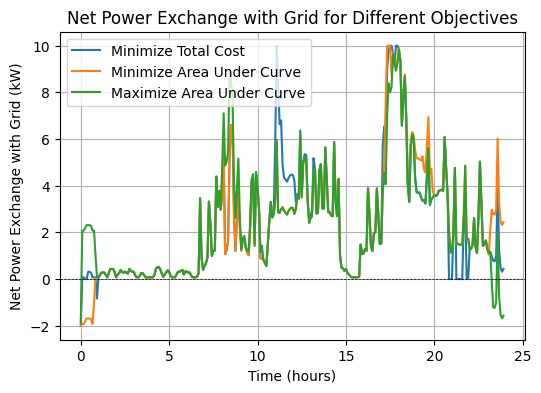

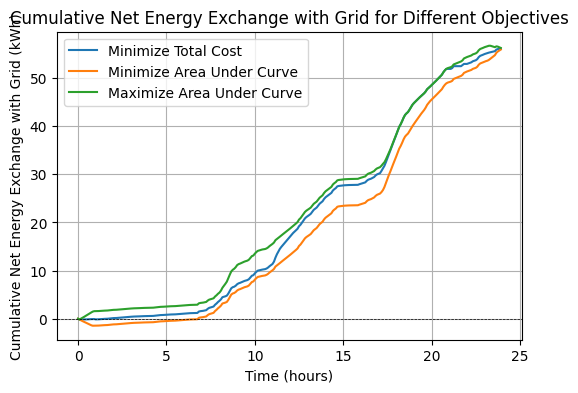


Summary of Results:

Objective: min_cost
Total Cost: 129.91 €
Area Under the Cumulative Net Energy Exchange Curve: 502.41 kWh·hours

Objective: min_area
Total Cost: 161.68 €
Area Under the Cumulative Net Energy Exchange Curve: 444.45 kWh·hours

Objective: max_area
Total Cost: 147.81 €
Area Under the Cumulative Net Energy Exchange Curve: 539.08 kWh·hours


In [11]:
# Function to convert time string to time step
def time_to_timestep(time_str):
    """
    Convert a time string in 'HH:MM' format to a time step (t) based on 5-minute resolution and 288 samples per day.

    Args:
        time_str (str): Time in 'HH:MM' format (e.g., '00:00', '07:00').

    Returns:
        int: Corresponding time step (0 to 287).
    """
    hours, minutes = map(int, time_str.split(':'))
    total_minutes = hours * 60 + minutes
    time_step = total_minutes // 5
    if time_step < 0 or time_step > 287:
        raise ValueError(f"Time step {time_step} is out of range (0 to 287) for time {time_str}")
    return time_step

# Function to convert time step to time string
def timestep_to_time(t):
    """
    Convert a time step (t) to 'HH:MM' format based on 5-minute resolution and 288 samples per day.

    Args:
        t (int): Time step (0 to 287).

    Returns:
        str: Time in 'HH:MM' format (e.g., '00:00', '07:05').
    """
    total_minutes = t * 5
    hours = total_minutes // 60
    minutes = total_minutes % 60
    return f"{hours:02d}:{minutes:02d}"

# Function to create and solve the model with a given objective
def create_and_solve_model(objective_type):
    # Define the Pyomo model
    model = ConcreteModel()

    # Sets
    model.L = Set(initialize=['l1', 'l2'])
    model.Lp = Set(initialize=[f'lp{i}' for i in range(1, 289)])
    model.T = Set(initialize=range(0, 288))

    # Define the Win_time dictionary (boundaries of restricted periods)
    Win_time = {'00:00', '08:00', '20:00', '23:59'}

    # Sort Win_time to ensure chronological order
    sorted_times = sorted(Win_time, key=lambda x: time_to_timestep(x))

    # Convert the time boundaries to time steps
    t1 = time_to_timestep(sorted_times[0])  # 00:00 -> t = 0
    t2 = time_to_timestep(sorted_times[1])  # 07:00 -> t = 84
    t3 = time_to_timestep(sorted_times[2])  # 20:00 -> t = 240
    t4 = time_to_timestep(sorted_times[3])  # 23:59 -> t = 287

    # Define restricted time steps (00:00 to 07:00 and 20:00 to 23:59)
    restricted_times = list(range(t1, t2)) + list(range(t3, t4 + 1))

    # Parameters
    model.P_SCH_A = Param(model.L, model.Lp, model.T, initialize=full_param_dict, default=0, doc="Power consumption profile of appliance l for load profile lp at time t (kW)")
    model.PV = Param(model.T, initialize=PV, doc="PV production (kW)")
    model.PL = Param(model.T, initialize=PL, doc="Demand (kW)")
    model.PRC = Param(model.T, initialize=PRC_pt, doc="Electricity price (€/kWh)")
    model.En_Nsch = Param(model.L, initialize=E_App, doc="Consumed energy by load l")

    # Decision Variables
    model.PinG = Var(model.T, within=NonNegativeReals, bounds=(0, 1000000), doc="Power imported from grid (kW)")
    model.PexG = Var(model.T, within=NonNegativeReals, bounds=(0, 1000000), doc="Power exported to grid (kW)")
    model.Bin_gi = Var(model.T, within=Binary, doc="Binary for importing from grid")
    model.Bin_go = Var(model.T, within=Binary, doc="Binary for exporting to grid")

    model.charge = Var(model.T, within=NonNegativeReals, bounds=(0, charging_rate), doc="Battery charging power (kW)")
    model.Bin_cess = Var(model.T, within=Binary, doc="Binary for charging ESS")
    model.discharge = Var(model.T, within=NonNegativeReals, bounds=(0, discharging_rate), doc="Battery discharging power (kW)")
    model.Bin_dess = Var(model.T, within=Binary, doc="Binary for discharging ESS")
    model.battery_level = Var(model.T, within=NonNegativeReals, bounds=(0, battery_capacity), doc="Battery energy level (kWh)")

    model.P_SCH = Var(model.L, model.T, within=NonNegativeReals, doc="Consumption of appliance l at time t")
    model.PL_SCH = Var(model.T, within=NonNegativeReals, doc="Consumption of appliance l at time t")
    model.B_SCH = Var(model.L, model.Lp, within=Binary, doc="Status of load l at each possible profile lp")

    # Variable: Net Energy Exchange with the grid at each time step (kWh)
    model.Net_Energy_Exchange = Var(model.T, within=Reals, doc="Net energy exchanged with grid at time t (kWh)")

    # Variable: Cumulative Net Energy Exchange up to time t (kWh)
    model.Cumulative_Net_Energy_Exchange = Var(model.T, within=Reals, doc="Cumulative net energy exchanged with grid up to time t (kWh)")

    # Variable: Area under the Cumulative_Net_Energy_Exchange curve (kWh·hours)
    model.Area_Under_Energy_Curve = Var(within=Reals, doc="Area under the cumulative net energy exchange curve (kWh·hours)")

    # Constraints
    # Constraint: Calculate Net Energy Exchange at each time step
    def net_energy_exchange_rule(model, t):
        delta_t = 5 / 60  # 5 minutes in hours
        return model.Net_Energy_Exchange[t] == (model.PinG[t] - model.PexG[t]) * delta_t
    model.net_energy_exchange_constr = Constraint(model.T, rule=net_energy_exchange_rule, doc="Net energy exchanged with grid at time t")

    # Constraint: Calculate Cumulative Net Energy Exchange up to time t
    def cumulative_net_energy_exchange_rule(model, t):
        if t == 0:
            return model.Cumulative_Net_Energy_Exchange[t] == 0  # No energy exchanged before t=0
        else:
            return model.Cumulative_Net_Energy_Exchange[t] == sum(model.Net_Energy_Exchange[tau] for tau in range(t))
    model.cumulative_net_energy_exchange_constr = Constraint(model.T, rule=cumulative_net_energy_exchange_rule, doc="Cumulative net energy exchanged with grid up to time t")

    # Constraint: Calculate the Area under the Cumulative_Net_Energy_Exchange curve
    def area_under_energy_curve_rule(model):
        delta_t = 5 / 60  # 5 minutes in hours
        return model.Area_Under_Energy_Curve == sum(model.Cumulative_Net_Energy_Exchange[t] * delta_t for t in model.T)
    model.area_under_energy_curve_constr = Constraint(rule=area_under_energy_curve_rule, doc="Area under the cumulative net energy exchange curve")

    # Constraint: Total Net Energy Exchange equals total (Loads - PV) over all T
    def total_net_energy_balance_rule(model):
        delta_t = 5 / 60  # 5 minutes in hours
        total_net_energy_exchange = sum(model.Net_Energy_Exchange[t] for t in model.T)
        total_loads_minus_pv = sum((model.PL[t] + model.PL_SCH[t]) * delta_t for t in model.T)
        return total_net_energy_exchange == total_loads_minus_pv
    model.total_net_energy_balance_constr = Constraint(rule=total_net_energy_balance_rule, doc="Total net energy exchange equals total loads over all T")

    # Constraint: Total load at time t
    def con6_rule(model, t):
        return model.PL_SCH[t] == sum(model.P_SCH[l, t] for l in model.L)
    model.Con6 = Constraint(model.T, rule=con6_rule, doc="Total load at time t")

    # Constraint: Power consumption of appliance l at time t
    def con8_rule(model, l, t):
        return model.P_SCH[l, t] == sum(model.B_SCH[l, lp] * model.P_SCH_A[l, lp, t] for lp in model.Lp)
    model.Con8 = Constraint(model.L, model.T, rule=con8_rule, doc="Power consumption of appliance l at time t")

    # Constraint: Exactly one profile selected for each load l
    def con9_rule(model, l):
        return sum(model.B_SCH[l, lp] for lp in model.Lp) == 1
    model.Con9 = Constraint(model.L, rule=con9_rule, doc="Exactly one profile selected for each load l")

    # Constraint: Total energy consumed by load l
    def con10_rule(model, l):
        return model.En_Nsch[l] == sum(model.B_SCH[l, lp] * model.P_SCH_A[l, lp, t] for t in model.T for lp in model.Lp) / (len(model.T) / 24)
    model.Con10 = Constraint(model.L, rule=con10_rule, doc="Total energy consumed by load l")

    # Constraint: No load scheduling during restricted periods (00:00-07:00 and 20:00-23:59)
    def no_load_during_restricted_periods_rule(model, l, t):
        if t in restricted_times:
            return model.P_SCH[l, t] == 0
        return Constraint.Skip
    model.no_load_during_restricted_periods = Constraint(model.L, model.T, rule=no_load_during_restricted_periods_rule, doc="No load scheduling during restricted periods defined by Win_time")

    # Energy balance constraint
    def energy_balance_rule(model, t):
        return model.PinG[t] + model.discharge[t] == model.PexG[t] + model.charge[t] + model.PL[t] + model.PL_SCH[t]
    model.energy_balance = Constraint(model.T, rule=energy_balance_rule, doc="Energy balance")

    # Grid exchange constraints
    def grid_import_limit_rule(model, t):
        return model.PinG[t] <= Exch_grid * model.Bin_gi[t]
    model.grid_import_limit = Constraint(model.T, rule=grid_import_limit_rule, doc="Grid import limit")

    def grid_export_limit_rule(model, t):
        return model.PexG[t] <= Exch_grid * model.Bin_go[t]
    model.grid_export_limit = Constraint(model.T, rule=grid_export_limit_rule, doc="Grid export limit")

    def grid_binary_rule(model, t):
        return model.Bin_gi[t] + model.Bin_go[t] <= 1
    model.grid_binary = Constraint(model.T, rule=grid_binary_rule, doc="Prevent simultaneous import/export")

    # Battery energy balance constraint
    def battery_level_rule(model, t):
        if t == 0:
            return model.battery_level[t] == 0.5 * battery_capacity  # Initial battery level
        else:
            # Adjust for 5-minute time step: 5 minutes = 5/60 hours
            return model.battery_level[t] == model.battery_level[t - 1] + (model.charge[t] * 0.95 * 5/60) - (model.discharge[t] / 0.95 * 5/60)
    model.battery_level_constr = Constraint(model.T, rule=battery_level_rule, doc="Battery energy balance")

    # Final battery level constraint (at t = 287)
    def final_battery_level_rule(model):
        return model.battery_level[287] == 0.5 * battery_capacity
    model.final_battery_level = Constraint(rule=final_battery_level_rule, doc="Final battery level same as initial")

    # Battery charging and discharging constraints
    def charge_limit_rule(model, t):
        return model.charge[t] <= charging_rate * model.Bin_cess[t]
    model.charge_limit = Constraint(model.T, rule=charge_limit_rule, doc="Charging limit")

    def discharge_limit_rule(model, t):
        return model.discharge[t] <= discharging_rate * model.Bin_dess[t]
    model.discharge_limit = Constraint(model.T, rule=discharge_limit_rule, doc="Discharging limit")

    def battery_binary_rule(model, t):
        return model.Bin_cess[t] + model.Bin_dess[t] <= 1
    model.battery_binary = Constraint(model.T, rule=battery_binary_rule, doc="Prevent simultaneous charge/discharge")

    # Define the objective based on the objective_type
    if objective_type == "min_cost":
        def objective_rule(model):
            return sum(model.PRC[t] * (model.PinG[t] - model.PexG[t]) for t in model.T)
        model.obj = Objective(rule=objective_rule, sense=minimize, doc="Minimize total cost")
    elif objective_type == "min_area":
        def objective_rule(model):
            return model.Area_Under_Energy_Curve
        model.obj = Objective(rule=objective_rule, sense=minimize, doc="Minimize area under the cumulative net energy exchange curve")
    elif objective_type == "max_area":
        def objective_rule(model):
            return model.Area_Under_Energy_Curve
        model.obj = Objective(rule=objective_rule, sense=maximize, doc="Maximize area under the cumulative net energy exchange curve")

    # Define solver options based on the objective type
    solver = SolverFactory('glpk')
    solver_options = {
        "min_cost": {
            "mipgap": 0.00001,  # Tight MIP gap
            "tmlim": 300,    # 5-minute time limit
        },
        "min_area": {
            "mipgap": 0.0000001,  # Tightened to 0.00001%
            "tmlim": 1500,        # 20-minute time limit
            "cuts": "",           # Enable cut generation
            "fpump": ""           # Enable feasibility pump heuristic
        },
        "max_area": {
            "mipgap": 0.0000001,  # Looser gap
            "tmlim": 400,    # 6-minute time limit
        }
    }

    # Solve the model with the appropriate options for the objective
    results = solver.solve(model, tee=True, options=solver_options[objective_type])

    # Check solver status and return results
    if results.solver.status == SolverStatus.ok and results.solver.termination_condition == TerminationCondition.optimal:
        # Collect all decision variables
        decision_vars = {
            "PinG": [model.PinG[t].value for t in model.T],
            "PexG": [model.PexG[t].value for t in model.T],
            "Bin_gi": [model.Bin_gi[t].value for t in model.T],
            "Bin_go": [model.Bin_go[t].value for t in model.T],
            "charge": [model.charge[t].value for t in model.T],
            "Bin_cess": [model.Bin_cess[t].value for t in model.T],
            "discharge": [model.discharge[t].value for t in model.T],
            "Bin_dess": [model.Bin_dess[t].value for t in model.T],
            "battery_level": [model.battery_level[t].value for t in model.T],
            "P_SCH_l1": [model.P_SCH['l1', t].value for t in model.T],
            "P_SCH_l2": [model.P_SCH['l2', t].value for t in model.T],
            "PL_SCH": [model.PL_SCH[t].value for t in model.T],
            "B_SCH_l1": [(lp, model.B_SCH['l1', lp].value) for lp in model.Lp],
            "B_SCH_l2": [(lp, model.B_SCH['l2', lp].value) for lp in model.Lp],
            "Net_Energy_Exchange": [model.Net_Energy_Exchange[t].value for t in model.T],
            "Cumulative_Net_Energy_Exchange": [model.Cumulative_Net_Energy_Exchange[t].value for t in model.T],
            "Area_Under_Energy_Curve": [model.Area_Under_Energy_Curve.value]  # Scalar value
        }

        # Calculate net power exchange with grid
        net_power_exchange = [model.PinG[t].value - model.PexG[t].value for t in model.T]
        cumulative_net_energy_exchange = [model.Cumulative_Net_Energy_Exchange[t].value for t in model.T]
        total_cost = sum(model.PRC[t] * (model.PinG[t].value - model.PexG[t].value) for t in model.T)
        area_value = model.Area_Under_Energy_Curve.value

        # Extract scheduling information for each appliance
        scheduling_info = {}
        for l in model.L:
            # Find the selected profile for appliance l
            selected_profile = None
            for lp, value in decision_vars[f"B_SCH_{l}"]:
                if value == 1:
                    selected_profile = lp
                    break

            # Get the power consumption over time for appliance l
            power_consumption = decision_vars[f"P_SCH_{l}"]

            # Identify the time periods when the appliance is active
            active_periods = []
            start_time = None
            for t in range(len(power_consumption)):
                if power_consumption[t] > 0 and start_time is None:
                    # Start of an active period
                    start_time = t
                elif power_consumption[t] == 0 and start_time is not None:
                    # End of an active period
                    end_time = t - 1
                    active_periods.append((start_time, end_time))
                    start_time = None
            # Check if the appliance is still active at the last time step
            if start_time is not None:
                active_periods.append((start_time, len(power_consumption) - 1))

            # Convert active periods to human-readable format
            active_periods_str = []
            for start, end in active_periods:
                start_str = timestep_to_time(start)
                end_str = timestep_to_time(end)
                active_periods_str.append(f"{start_str} to {end_str}")

            scheduling_info[l] = {
                "selected_profile": selected_profile,
                "active_periods": active_periods_str,
                "power_consumption": power_consumption  # For Excel output
            }

        return decision_vars, net_power_exchange, cumulative_net_energy_exchange, total_cost, area_value, scheduling_info, True
    else:
        print(f"Optimization did not converge for {objective_type}.")
        print(f"Solver Status: {results.solver.status}")
        print(f"Termination Condition: {results.solver.termination_condition}")
        return None, None, None, None, None, None, False

# Solve the model with each objective and collect results
objectives = ["min_cost", "min_area", "max_area"]
results = {}

for obj_type in objectives:
    print(f"\nSolving for objective: {obj_type}")
    decision_vars, net_power_exchange, cumulative_net_energy_exchange, total_cost, area_value, scheduling_info, success = create_and_solve_model(obj_type)
    if success:
        results[obj_type] = {
            "decision_vars": decision_vars,
            "net_power_exchange": net_power_exchange,
            "cumulative_net_energy_exchange": cumulative_net_energy_exchange,
            "total_cost": total_cost,
            "area_value": area_value,
            "scheduling_info": scheduling_info
        }

# Print scheduling information for each objective and appliance
for obj_type in results:
    print(f"\nScheduling Information for Objective: {obj_type}")
    for appliance in ['l1', 'l2']:
        info = results[obj_type]["scheduling_info"][appliance]
        print(f"\nAppliance: {appliance}")
        print(f"Selected Profile: {info['selected_profile']}")
        if info['active_periods']:
            print("Active Periods:")
            for period in info['active_periods']:
                print(f"  - {period}")
        else:
            print("Appliance is not scheduled (no active periods).")

# Export decision variables to Excel (one file per objective, with each variable in a separate sheet)
for obj_type in results:
    with pd.ExcelWriter(f'decision_variables_{obj_type}.xlsx') as writer:
        # Variables indexed by T (time steps)
        for var_name in ["PinG", "PexG", "Bin_gi", "Bin_go", "charge", "Bin_cess", "discharge", "Bin_dess",
                         "battery_level", "P_SCH_l1", "P_SCH_l2", "PL_SCH", "Net_Energy_Exchange",
                         "Cumulative_Net_Energy_Exchange"]:
            df = pd.DataFrame(results[obj_type]["decision_vars"][var_name], columns=[var_name], index=range(288))
            df.index.name = 'Time_Step'
            df['Time (HH:MM)'] = [timestep_to_time(t) for t in range(288)]
            df.to_excel(writer, sheet_name=var_name)

        # B_SCH variables (indexed by L and Lp)
        for var_name in ["B_SCH_l1", "B_SCH_l2"]:
            df = pd.DataFrame(results[obj_type]["decision_vars"][var_name], columns=['Lp', var_name])
            df.to_excel(writer, sheet_name=var_name, index=False)

        # Scalar variable (Area_Under_Energy_Curve)
        df = pd.DataFrame(results[obj_type]["decision_vars"]["Area_Under_Energy_Curve"], columns=["Area_Under_Energy_Curve"])
        df.to_excel(writer, sheet_name="Area_Under_Energy_Curve", index=False)

        # Add scheduling information for each appliance
        for appliance in ['l1', 'l2']:
            info = results[obj_type]["scheduling_info"][appliance]
            # Create a DataFrame for power consumption over time
            df_power = pd.DataFrame({
                f"P_SCH_{appliance} (kW)": info["power_consumption"],
                "Time (HH:MM)": [timestep_to_time(t) for t in range(288)]
            }, index=range(288))
            df_power.index.name = 'Time_Step'
            df_power.to_excel(writer, sheet_name=f"Schedule_{appliance}")

            # Create a DataFrame for active periods
            df_active = pd.DataFrame({
                "Selected Profile": [info["selected_profile"]],
                "Active Periods": [", ".join(info["active_periods"]) if info["active_periods"] else "None"]
            })
            df_active.to_excel(writer, sheet_name=f"Active_Periods_{appliance}", index=False)

    # Download the Excel file
    files.download(f'decision_variables_{obj_type}.xlsx')

# Plot the Net Power Exchange with Grid for all objectives
time_hours = [t / 12 for t in range(288)]  # Convert time steps to hours

plt.figure(figsize=(6, 4))
for obj_type, data in results.items():
    label = {
        "min_cost": "Minimize Total Cost",
        "min_area": "Minimize Area Under Curve",
        "max_area": "Maximize Area Under Curve"
    }[obj_type]
    plt.plot(time_hours, data["net_power_exchange"], label=label)
plt.xlabel('Time (hours)')
plt.ylabel('Net Power Exchange with Grid (kW)')
plt.title('Net Power Exchange with Grid for Different Objectives')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()

# Plot: Cumulative Net Energy Exchange with Grid for all objectives
plt.figure(figsize=(6, 4))
for obj_type, data in results.items():
    label = {
        "min_cost": "Minimize Total Cost",
        "min_area": "Minimize Area Under Curve",
        "max_area": "Maximize Area Under Curve"
    }[obj_type]
    plt.plot(time_hours, data["cumulative_net_energy_exchange"], label=label)
plt.xlabel('Time (hours)')
plt.ylabel('Cumulative Net Energy Exchange with Grid (kWh)')
plt.title('Cumulative Net Energy Exchange with Grid for Different Objectives')
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.grid(True)
plt.legend()
plt.show()

# Print the objective values for each case
print("\nSummary of Results:")
for obj_type, data in results.items():
    print(f"\nObjective: {obj_type}")
    print(f"Total Cost: {data['total_cost']:.2f} €")
    print(f"Area Under the Cumulative Net Energy Exchange Curve: {data['area_value']:.2f} kWh·hours")

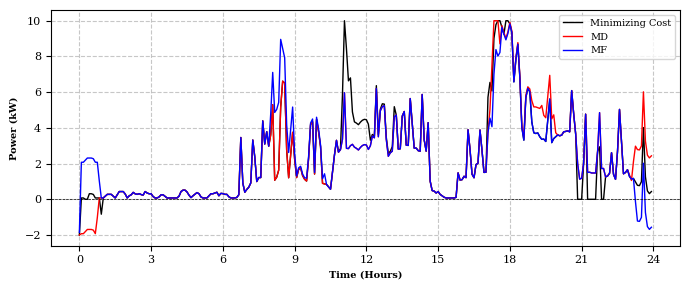

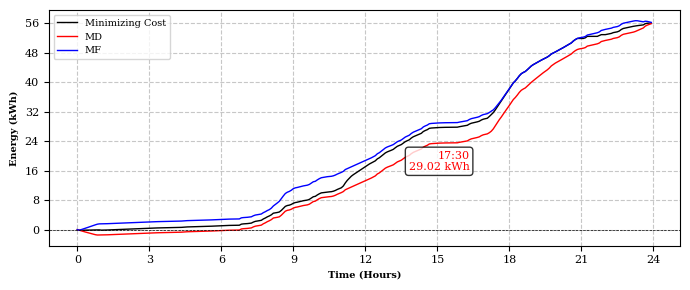


Summary of Results:

Objective: min_cost
Total Cost: 129.91 €
Area Under the Cumulative Net Energy Exchange Curve: 502.41 kWh·hours

Objective: min_area
Total Cost: 161.68 €
Area Under the Cumulative Net Energy Exchange Curve: 444.45 kWh·hours

Objective: max_area
Total Cost: 147.81 €
Area Under the Cumulative Net Energy Exchange Curve: 539.08 kWh·hours


In [14]:
# Plotting with Arbitrary Annotations and Improved Positioning
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from google.colab import files

# --- Customization Options ---
FIG_WIDTH = 7   # Width of the figure in inches
FIG_HEIGHT = 3   # Height of the figure in inches

# Axis Label Customization
AXIS_LABEL_FONT = "DejaVu Serif"
AXIS_LABEL_SIZE = 7
AXIS_LABEL_WEIGHT = "bold"  # "normal" or "bold"

# Axis Tick Customization
X_NUM_TICKS = 12  # Number of ticks on the x-axis
Y_NUM_TICKS = 8   # Number of ticks on the y-axis
TICK_LABEL_FONT = "DejaVu Serif"
TICK_LABEL_SIZE = 8
TICK_LABEL_WEIGHT = "normal"  # "normal" or "bold"

# Annotation Customization
ANNOTATION_FONT = "DejaVu Serif"
ANNOTATION_SIZE = 8
ANNOTATION_OFFSET_MAGNITUDE = 20  # Magnitude of the offset in points

TITLE_FONT = "DejaVu Serif"
TITLE_SIZE = 6
TITLE_WEIGHT = "bold"

LEGEND_FONT = "DejaVu Serif"
LEGEND_SIZE = 7
LEGEND_WEIGHT = "normal"

# Curve Style Options
LINE_STYLES = ['-', '-', '-']    # List of available line styles
CURVE_COLORS = ['black', 'red', 'blue']    # List of available curve colors
LINE_WIDTHS = {   # Dictionary to specify line width for each objective
    "min_cost": 1.0,
    "min_area": 1.0,
    "max_area": 1.0
}

GRID_STYLE = "--"
GRID_ALPHA = 0.7

# --- Helper Function to Determine Annotation Position ---
def get_annotation_position(x_data, y_data, annotate_time_step, plot_ylim, index_in_curve):
    """
    Determine the best position for an annotation based on the curve's slope and plot boundaries.

    Args:
        x_data (list): X-axis data (time in hours).
        y_data (list): Y-axis data for the curve.
        annotate_time_step (int): Time step of the annotation point.
        plot_ylim (tuple): (ymin, ymax) of the plot.
        index_in_curve (int): Index of this annotation in the curve (for alternating offsets).

    Returns:
        tuple: (offset, ha, va) - offset in points, horizontal alignment, vertical alignment.
    """
    # Get the y-value at the annotation point
    y_val = y_data[annotate_time_step]
    ymin, ymax = plot_ylim

    # Calculate the slope at the annotation point (approximate using neighboring points)
    if annotate_time_step > 0 and annotate_time_step < len(y_data) - 1:
        slope = (y_data[annotate_time_step + 1] - y_data[annotate_time_step - 1]) / (x_data[annotate_time_step + 1] - x_data[annotate_time_step - 1])
    elif annotate_time_step == 0:
        slope = (y_data[1] - y_data[0]) / (x_data[1] - x_data[0])
    else:
        slope = (y_data[-1] - y_data[-2]) / (x_data[-1] - x_data[-2])

    # Determine position based on slope and y-value
    if slope > 0:  # Curve is increasing
        if y_val < (ymin + ymax) / 2:  # Point is in the lower half of the plot
            offset = (ANNOTATION_OFFSET_MAGNITUDE, ANNOTATION_OFFSET_MAGNITUDE)  # Above and to the right
            ha, va = "left", "bottom"
        else:  # Point is in the upper half
            offset = (-ANNOTATION_OFFSET_MAGNITUDE, -ANNOTATION_OFFSET_MAGNITUDE)  # Below and to the left
            ha, va = "right", "top"
    elif slope < 0:  # Curve is decreasing
        if y_val < (ymin + ymax) / 2:  # Point is in the lower half
            offset = (ANNOTATION_OFFSET_MAGNITUDE, ANNOTATION_OFFSET_MAGNITUDE)  # Above and to the right
            ha, va = "left", "bottom"
        else:  # Point is in the upper half
            offset = (-ANNOTATION_OFFSET_MAGNITUDE, -ANNOTATION_OFFSET_MAGNITUDE)  # Below and to the left
            ha, va = "right", "top"
    else:  # Curve is flat
        if y_val < (ymin + ymax) / 2:  # Point is in the lower half
            offset = (0, ANNOTATION_OFFSET_MAGNITUDE)  # Directly above
            ha, va = "center", "bottom"
        else:  # Point is in the upper half
            offset = (0, -ANNOTATION_OFFSET_MAGNITUDE)  # Directly below
            ha, va = "center", "top"

    # Alternate offset direction for multiple annotations on the same curve
    if index_in_curve % 2 == 1:  # For odd-numbered annotations, flip the vertical offset
        offset = (offset[0], -offset[1])
        va = "top" if va == "bottom" else "bottom"

    return offset, ha, va

# --- Plotting Function with Arbitrary Annotations ---
def create_plot_with_annotations(
    x_data, y_data, x_label, y_label, title, legend_labels, annotate_times,
    energy_unit="kW", show_title=True, x_num_ticks=X_NUM_TICKS, y_num_ticks=Y_NUM_TICKS
):
    """
    Create a plot with arbitrary annotations for each curve, with text color matching the curve.

    Args:
        x_data (list): X-axis data (e.g., time in hours).
        y_data (list of lists): Y-axis data for each curve.
        x_label (str): Label for the x-axis.
        y_label (str): Label for the y-axis.
        title (str): Title of the plot.
        legend_labels (list): Labels for the legend (one per curve).
        annotate_times (list of lists): List of times in 'HH:MM' format to annotate for each curve.
                                       e.g., [['08:00'], ['12:00', '15:00'], []] annotates min_cost at 08:00,
                                       min_area at 12:00 and 15:00, and nothing for max_area.
        energy_unit (str): Unit of the energy value (e.g., 'kW' or 'kWh').
        show_title (bool): Whether to display the title (default: True).
        x_num_ticks (int): Number of ticks on the x-axis (default: X_NUM_TICKS).
        y_num_ticks (int): Number of ticks on the y-axis (default: Y_NUM_TICKS).
    """
    # Create a new figure for the first pass (to determine y-limits)
    fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

    # First pass: Plot curves to determine y-limits
    for i, (obj_type, y) in enumerate(zip(results.keys(), y_data)):
        style_index = i % len(LINE_STYLES)
        color_index = i % len(CURVE_COLORS)
        line_width = LINE_WIDTHS.get(obj_type, 1.0)
        curve_color = CURVE_COLORS[color_index]  # Color of the curve
        plt.plot(x_data, y, label=legend_labels[i],
                 linewidth=line_width, linestyle=LINE_STYLES[style_index], color=curve_color)

    # Get the y-limits of the plot after plotting all curves
    plot_ylim = plt.ylim()

    # Close the first figure to prevent it from displaying
    plt.close(fig)

    # Create a new figure for the final plot
    plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

    # Second pass: Plot curves with annotations
    for i, (obj_type, y) in enumerate(zip(results.keys(), y_data)):
        style_index = i % len(LINE_STYLES)
        color_index = i % len(CURVE_COLORS)
        line_width = LINE_WIDTHS.get(obj_type, 1.0)
        curve_color = CURVE_COLORS[color_index]  # Color of the curve
        plt.plot(x_data, y, label=legend_labels[i],
                 linewidth=line_width, linestyle=LINE_STYLES[style_index], color=curve_color)

        # Add annotations for this curve if specified
        if i < len(annotate_times) and annotate_times[i]:  # Check if there are times to annotate
            for idx, annotate_time_str in enumerate(annotate_times[i]):
                annotate_time_step = time_to_timestep(annotate_time_str)  # Convert time to time step
                annotate_time_hours = annotate_time_step / 12  # Convert to hours for x-axis

                if 0 <= annotate_time_step < len(y):
                    x_val = annotate_time_hours  # Time in hours
                    y_val = y[annotate_time_step]  # Energy value at the time step
                    annotation_text = f"{annotate_time_str}\n{y_val:.2f} {energy_unit}"

                    # Determine the best position for the annotation
                    offset, ha, va = get_annotation_position(x_data, y, annotate_time_step, plot_ylim, idx)

                    plt.annotate(annotation_text,
                                 xy=(x_val, y_val),
                                 xytext=offset,
                                 textcoords="offset points",
                                 fontname=ANNOTATION_FONT,
                                 fontsize=ANNOTATION_SIZE,
                                 color=curve_color,  # Match the annotation color to the curve color
                                 ha=ha,
                                 va=va,
                                 bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8))

    # Set axis labels
    plt.xlabel(x_label, fontname=AXIS_LABEL_FONT, fontsize=AXIS_LABEL_SIZE, fontweight=AXIS_LABEL_WEIGHT)
    plt.ylabel(y_label, fontname=AXIS_LABEL_FONT, fontsize=AXIS_LABEL_SIZE, fontweight=AXIS_LABEL_WEIGHT)

    # Set the number of ticks on the x-axis and y-axis
    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=x_num_ticks))
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=y_num_ticks))

    # Customize the font properties of the tick labels
    plt.tick_params(axis='both', which='major', labelsize=TICK_LABEL_SIZE)
    for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
        label.set_fontname(TICK_LABEL_FONT)
        label.set_fontweight(TICK_LABEL_WEIGHT)

    # Set the title if specified
    if show_title:
        plt.title(title, fontname=TITLE_FONT, fontsize=TITLE_SIZE, fontweight=TITLE_WEIGHT)

    plt.grid(True, linestyle=GRID_STYLE, alpha=GRID_ALPHA)
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.legend(prop={'family': LEGEND_FONT, 'size': LEGEND_SIZE, 'weight': LEGEND_WEIGHT})
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

# --- Plotting ---
time_hours = [t / 12 for t in range(288)]  # Convert time steps to hours

# Example: Annotate some curves with multiple points
net_power_annotate_times = [[], [], []]  # No annotations for net power plot
cumulative_annotate_times = [[], ['17:30'], []]  # Annotate max_area at 10:00 for cumulative plot

# Plot the Net Power Exchange with Grid for all objectives
net_power_exchange_data = [data["net_power_exchange"] for data in results.values()]
legend_labels_net_power = [
    {"min_cost": "Minimizing Cost", "min_area": "MD", "max_area": "MF"}[obj]
    for obj in results.keys()
]
create_plot_with_annotations(
    time_hours,
    net_power_exchange_data,
    'Time (Hours)',
    'Power (kW)',
    'Net Power Exchange with Grid for Different Objectives',
    legend_labels_net_power,
    annotate_times=net_power_annotate_times,
    energy_unit="kW",
    show_title=False,
    x_num_ticks=10,  # Number of ticks on the x-axis
    y_num_ticks=8    # Number of ticks on the y-axis
)

# Plot: Cumulative Net Energy Exchange with Grid for all objectives
cumulative_net_energy_data = [data["cumulative_net_energy_exchange"] for data in results.values()]
legend_labels_cumulative_net = [
    {"min_cost": "Minimizing Cost", "min_area": "MD", "max_area": "MF"}[obj]
    for obj in results.keys()
]
create_plot_with_annotations(
    time_hours,
    cumulative_net_energy_data,
    'Time (Hours)',
    'Energy (kWh)',
    'Cumulative Net Energy Exchange with Grid for Different Objectives',
    legend_labels_cumulative_net,
    annotate_times=cumulative_annotate_times,
    energy_unit="kWh",
    show_title=False,
    x_num_ticks=10,  # Number of ticks on the x-axis
    y_num_ticks=8    # Number of ticks on the y-axis
)

# Print the objective values for each case
print("\nSummary of Results:")
for obj_type, data in results.items():
    print(f"\nObjective: {obj_type}")
    print(f"Total Cost: {data['total_cost']:.2f} €")
    print(f"Area Under the Cumulative Net Energy Exchange Curve: {data['area_value']:.2f} kWh·hours")

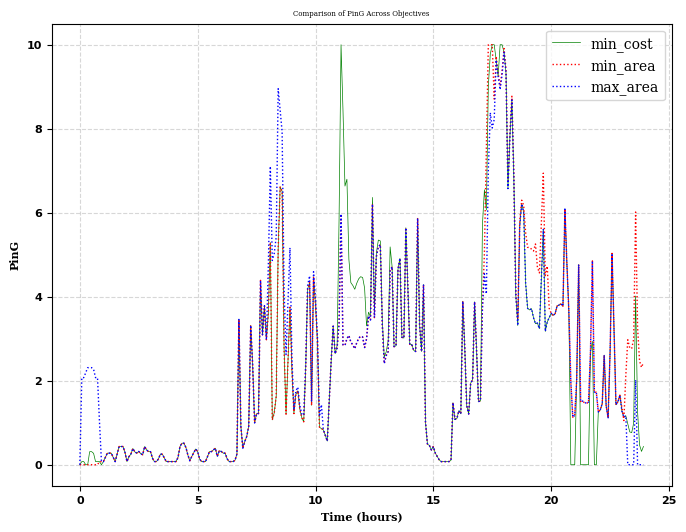

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

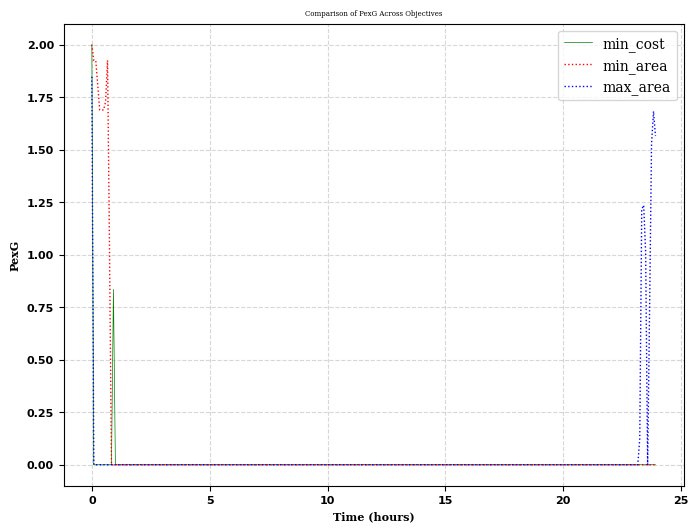

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

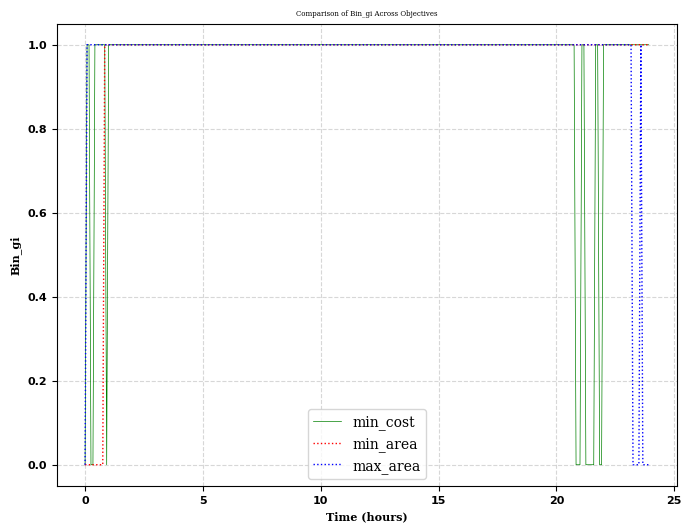

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

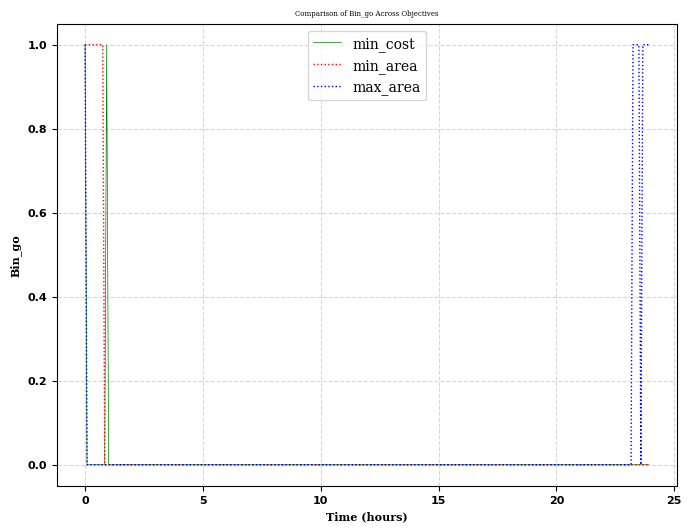

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

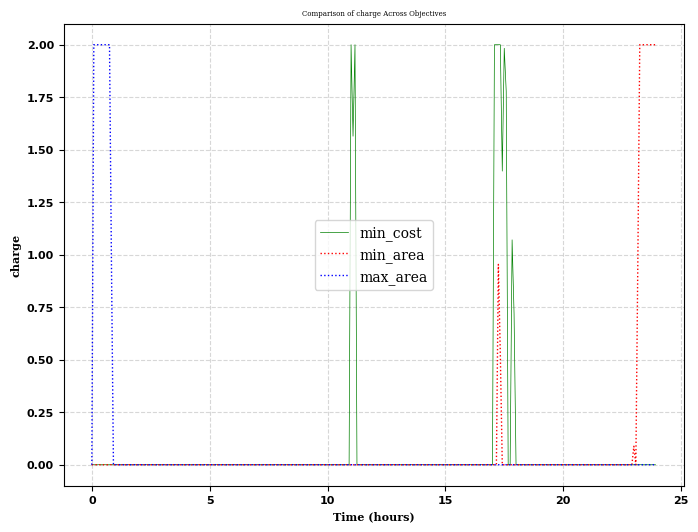

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

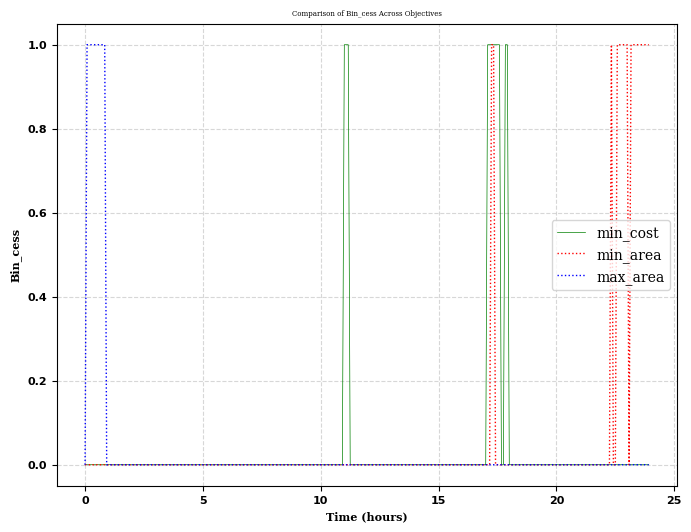

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

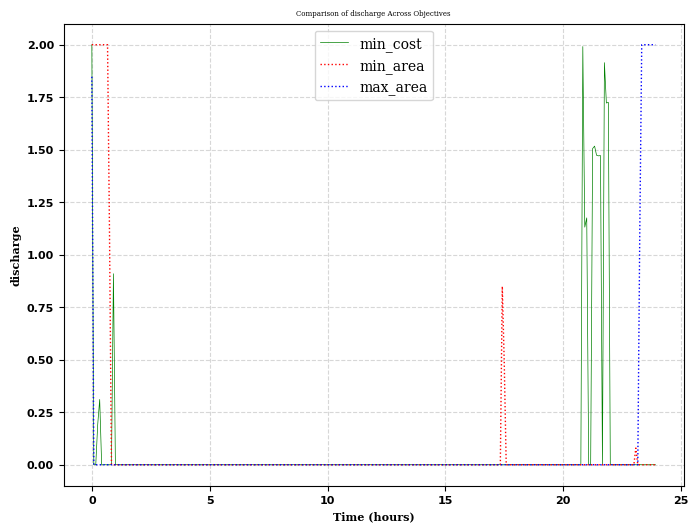

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

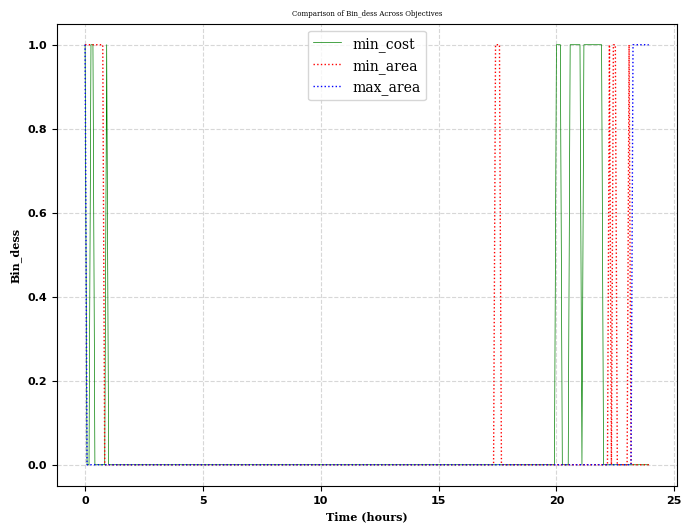

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

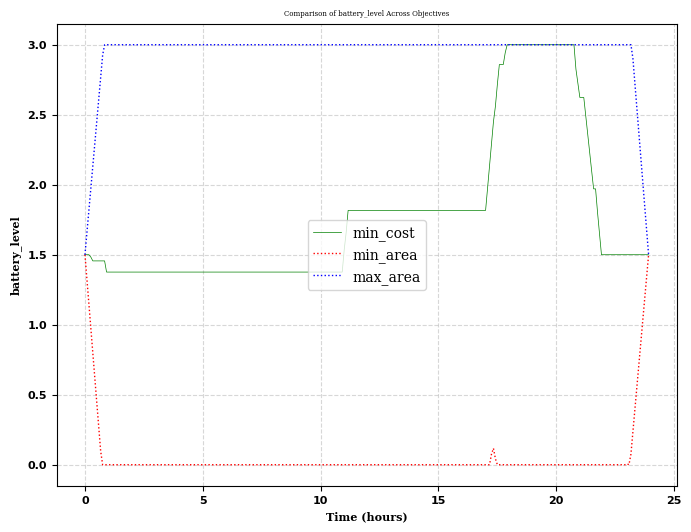

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

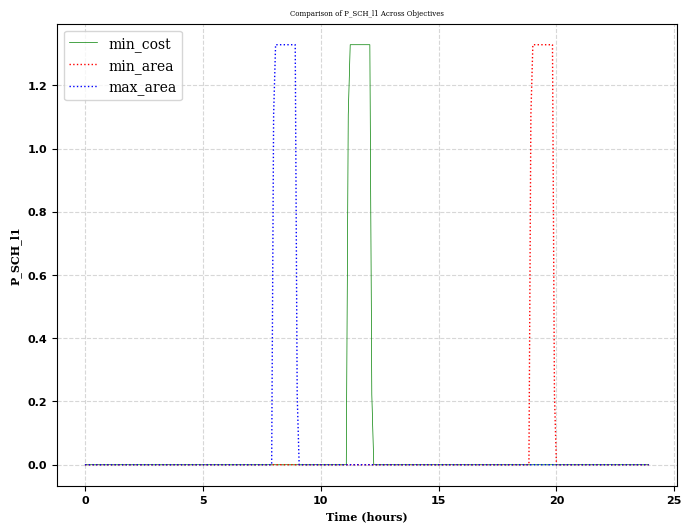

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

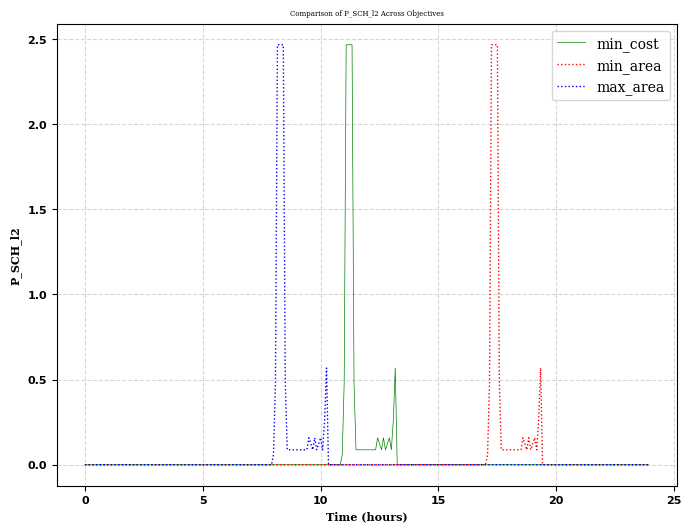

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

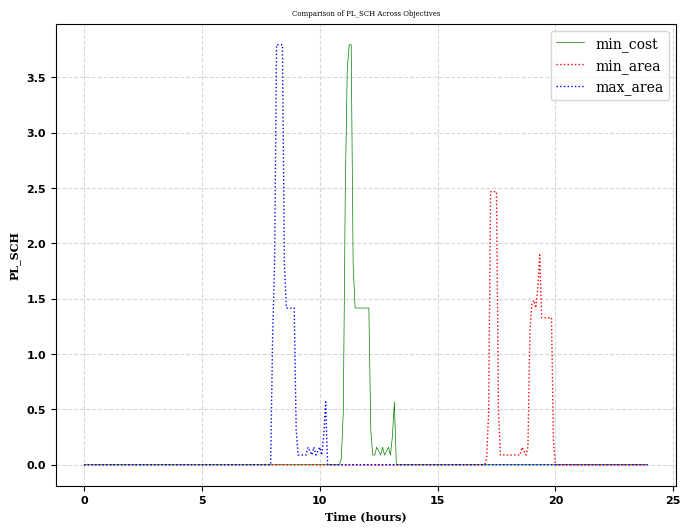

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

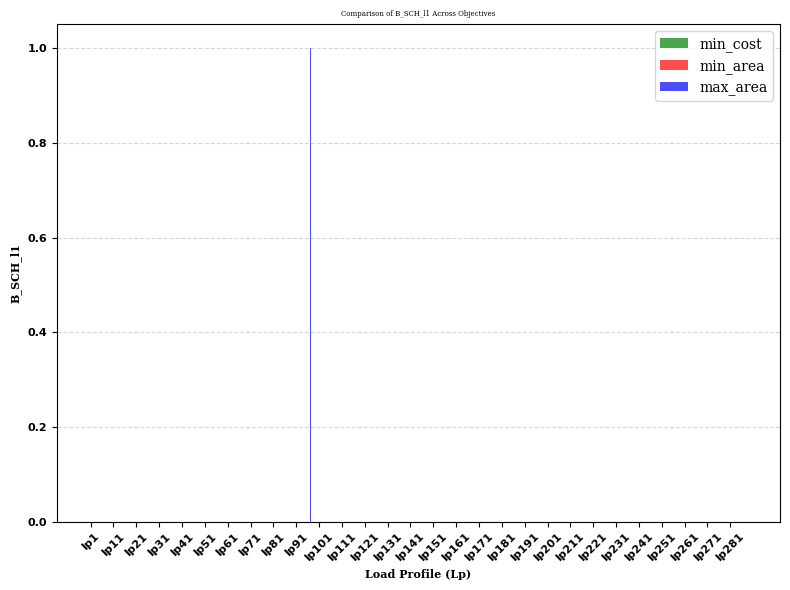

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

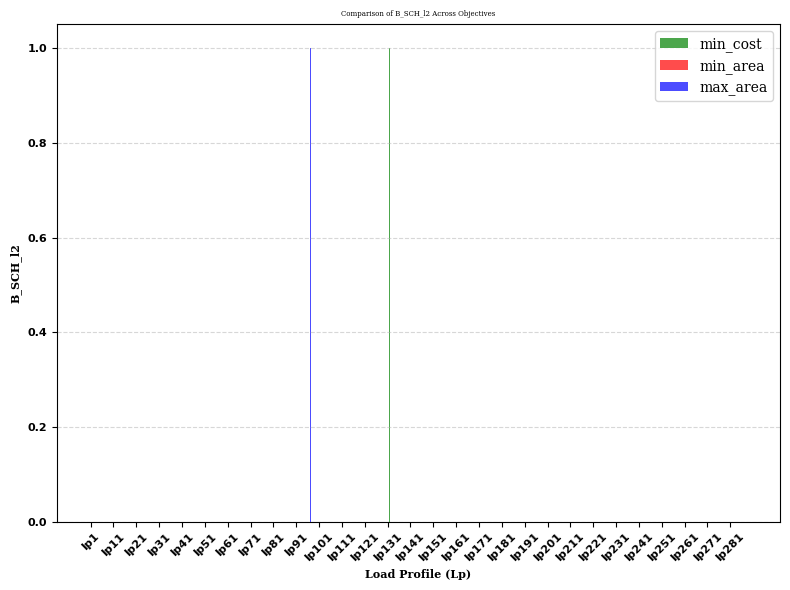

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

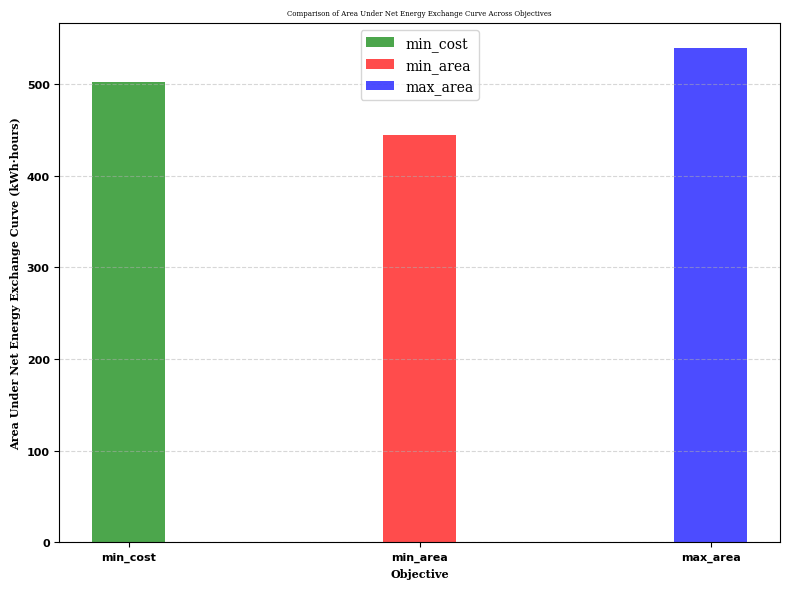

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

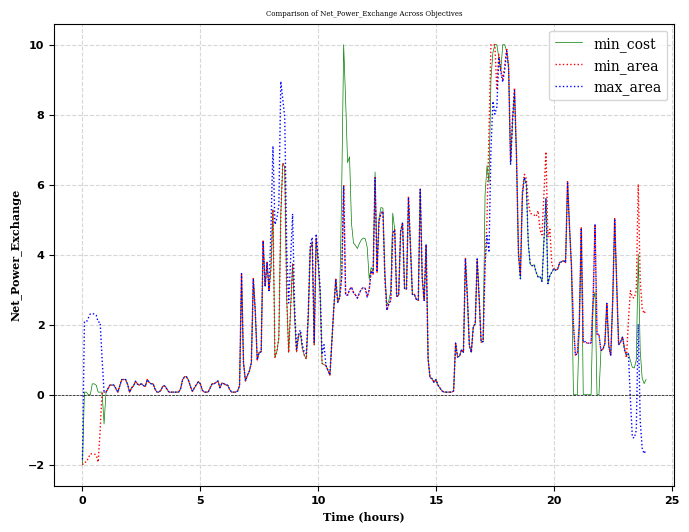

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

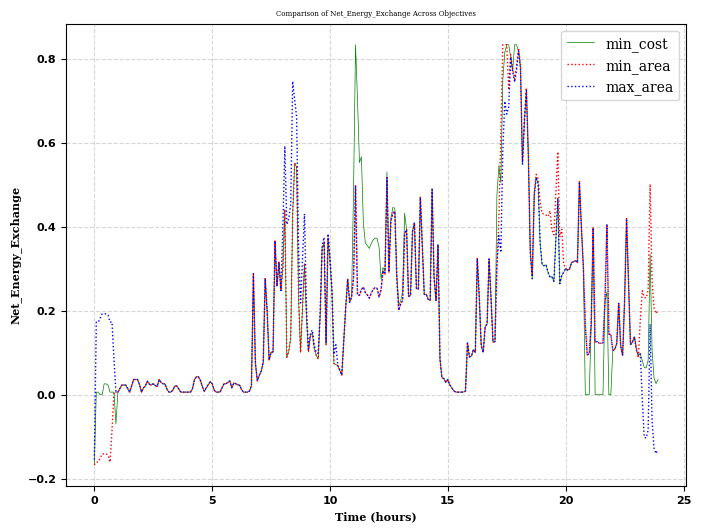

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

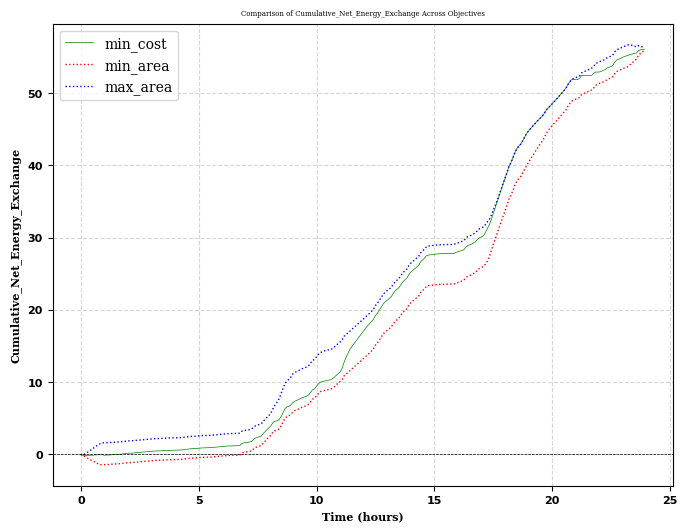

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Customization Options (Modify these as needed)
# Figure size
FIG_WIDTH = 8
FIG_HEIGHT = 6

# Colors for each objective
COLORS = {
    "min_cost": "green",
    "min_area": "red",
    "max_area": "blue"
}

# Line styles for each objective (for line plots)
LINE_STYLES = {
    "min_cost": "-",  # Solid
    "min_area": ":",  # Dashed
    "max_area": ":"   # Dotted
}

# Line widths for each objective (for line plots)
LINE_WIDTHS = {
    "min_cost": 0.5,  # Line width for min_cost
    "min_area": 1.0,  # Line width for min_area
    "max_area": 1.0   # Line width for max_area
}

# Axis labels
AXIS_LABEL_FONT = "DejaVu Serif"
AXIS_LABEL_SIZE = 8
AXIS_LABEL_WEIGHT = "bold"  # Options: "normal", "bold"

# Title
TITLE_FONT = "DejaVu Serif"
TITLE_SIZE = 5
TITLE_WEIGHT = "normal"  # Options: "normal", "bold"

# Legend
LEGEND_FONT = "DejaVu Serif"  # Font type for legend
LEGEND_FONT_SIZE = 4
LEGEND_WEIGHT = "normal"  # Options: "normal", "bold"
LEGEND_LOCATION = "best"  # Position of the legend; Options: "upper right", "upper left", "lower right", "lower left", "center", "best", etc.

# Tick labels
TICK_LABEL_SIZE = 8
TICK_LABEL_ROTATION = 45  # Rotation for x-axis labels (useful for B_SCH plots)
TICK_LABEL_WEIGHT = "bold"  # Options: "normal", "bold"

# Bar chart settings
BAR_WIDTH = 0.25
BAR_ALPHA = 0.7  # Transparency for bars

# Grid settings
SHOW_GRID = True
GRID_STYLE = "--"
GRID_ALPHA = 0.5

# List of objectives
objectives = ["min_cost", "min_area", "max_area"]

# List of decision variables (including Net_Power_Exchange, excluding removed variables)
decision_vars = [
    "PinG", "PexG", "Bin_gi", "Bin_go", "charge", "Bin_cess", "discharge", "Bin_dess",
    "battery_level", "P_SCH_l1", "P_SCH_l2", "PL_SCH",
    "B_SCH_l1", "B_SCH_l2", "Area_Under_Energy_Curve", "Net_Power_Exchange", "Net_Energy_Exchange",
    "Cumulative_Net_Energy_Exchange"
]

# Time steps converted to hours for plotting (288 time steps = 24 hours)
time_hours = [t / 12 for t in range(288)]

# Dictionary to store data for each objective
data = {}

# Step 1: Read the Excel files for each objective
for obj_type in objectives:
    file_name = f'decision_variables_{obj_type}.xlsx'
    try:
        # Read all sheets from the Excel file
        excel_data = pd.read_excel(file_name, sheet_name=None)
        data[obj_type] = excel_data
    except FileNotFoundError:
        print(f"File {file_name} not found. Uploading the file...")
        uploaded = files.upload()
        if file_name in uploaded:
            excel_data = pd.read_excel(file_name, sheet_name=None)
            data[obj_type] = excel_data
        else:
            raise FileNotFoundError(f"Could not find or upload {file_name}.")

# Step 2: Calculate Net Power Exchange for each objective
for obj_type in objectives:
    # Extract PinG and PexG from the Excel data
    pinG = data[obj_type]["PinG"]["PinG"].values
    pexG = data[obj_type]["PexG"]["PexG"].values
    # Calculate Net Power Exchange (PinG - PexG)
    net_power_exchange = pinG - pexG
    # Add Net Power Exchange as a new DataFrame to the data dictionary
    data[obj_type]["Net_Power_Exchange"] = pd.DataFrame(net_power_exchange, columns=["Net_Power_Exchange"])

# Step 3: Plot each decision variable in a separate figure
for var_name in decision_vars:
    # Create a new figure
    fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))

    if var_name in ["B_SCH_l1", "B_SCH_l2"]:
        # Plot B_SCH variables as bar charts
        for i, obj_type in enumerate(objectives):
            df = data[obj_type][var_name]
            lp_values = df['Lp']
            values = df[var_name]
            # Offset the bars for each objective
            positions = [x + i * BAR_WIDTH for x in range(len(lp_values))]
            plt.bar(positions, values, width=BAR_WIDTH, label=obj_type, alpha=BAR_ALPHA, color=COLORS[obj_type])

        # Customize x-axis to show fewer labels (every 10th Lp) to avoid clutter
        plt.xlabel('Load Profile (Lp)', fontname=AXIS_LABEL_FONT, fontsize=AXIS_LABEL_SIZE, fontweight=AXIS_LABEL_WEIGHT)
        plt.ylabel(var_name, fontname=AXIS_LABEL_FONT, fontsize=AXIS_LABEL_SIZE, fontweight=AXIS_LABEL_WEIGHT)
        plt.title(f'Comparison of {var_name} Across Objectives', fontname=TITLE_FONT, fontsize=TITLE_SIZE, fontweight=TITLE_WEIGHT)
        plt.xticks([x + BAR_WIDTH for x in range(0, len(lp_values), 10)], lp_values[::10],
                   rotation=TICK_LABEL_ROTATION, fontsize=TICK_LABEL_SIZE, fontweight=TICK_LABEL_WEIGHT)
        plt.yticks(fontsize=TICK_LABEL_SIZE, fontweight=TICK_LABEL_WEIGHT)
        plt.legend(fontsize=LEGEND_FONT_SIZE, prop={'family': LEGEND_FONT, 'weight': LEGEND_WEIGHT}, loc=LEGEND_LOCATION)
        if SHOW_GRID:
            plt.grid(True, axis='y', linestyle=GRID_STYLE, alpha=GRID_ALPHA)
        plt.tight_layout()

    elif var_name == "Area_Under_Energy_Curve":
        # Plot Area_Under_Energy_Curve as a bar chart (scalar value)
        bars = []
        for i, obj_type in enumerate(objectives):
            value = data[obj_type][var_name].iloc[0, 0]
            bar = plt.bar(i, value, width=BAR_WIDTH, label=obj_type, alpha=BAR_ALPHA, color=COLORS[obj_type])
            bars.append(bar)
        plt.xlabel('Objective', fontname=AXIS_LABEL_FONT, fontsize=AXIS_LABEL_SIZE, fontweight=AXIS_LABEL_WEIGHT)
        plt.ylabel('Area Under Net Energy Exchange Curve (kWh·hours)', fontname=AXIS_LABEL_FONT, fontsize=AXIS_LABEL_SIZE, fontweight=AXIS_LABEL_WEIGHT)
        plt.title('Comparison of Area Under Net Energy Exchange Curve Across Objectives', fontname=TITLE_FONT, fontsize=TITLE_SIZE, fontweight=TITLE_WEIGHT)
        plt.xticks([i for i in range(len(objectives))], objectives, fontsize=TICK_LABEL_SIZE, fontweight=TICK_LABEL_WEIGHT)
        plt.yticks(fontsize=TICK_LABEL_SIZE, fontweight=TICK_LABEL_WEIGHT)
        plt.legend(fontsize=LEGEND_FONT_SIZE, prop={'family': LEGEND_FONT, 'weight': LEGEND_WEIGHT}, loc=LEGEND_LOCATION)
        if SHOW_GRID:
            plt.grid(True, axis='y', linestyle=GRID_STYLE, alpha=GRID_ALPHA)
        plt.tight_layout()

    else:
        # Plot variables indexed by T as line graphs (including Net_Power_Exchange)
        for obj_type in objectives:
            df = data[obj_type][var_name]
            values = df[var_name]
            plt.plot(time_hours, values, label=obj_type, color=COLORS[obj_type], linestyle=LINE_STYLES[obj_type], linewidth=LINE_WIDTHS[obj_type])
        plt.xlabel('Time (hours)', fontname=AXIS_LABEL_FONT, fontsize=AXIS_LABEL_SIZE, fontweight=AXIS_LABEL_WEIGHT)
        plt.ylabel(var_name, fontname=AXIS_LABEL_FONT, fontsize=AXIS_LABEL_SIZE, fontweight=AXIS_LABEL_WEIGHT)
        plt.title(f'Comparison of {var_name} Across Objectives', fontname=TITLE_FONT, fontsize=TITLE_SIZE, fontweight=TITLE_WEIGHT)
        plt.xticks(fontsize=TICK_LABEL_SIZE, fontweight=TICK_LABEL_WEIGHT)
        plt.yticks(fontsize=TICK_LABEL_SIZE, fontweight=TICK_LABEL_WEIGHT)
        if var_name == "Net_Power_Exchange" or var_name == "Cumulative_Net_Energy_Exchange":
            plt.axhline(0, color='black', linestyle='--', linewidth=0.5)  # Add a zero line for clarity
        if SHOW_GRID:
            plt.grid(True, linestyle=GRID_STYLE, alpha=GRID_ALPHA)
        plt.legend(fontsize=LEGEND_FONT_SIZE, prop={'family': LEGEND_FONT, 'weight': LEGEND_WEIGHT}, loc=LEGEND_LOCATION)

    # Save the plot before showing or closing
    plt.savefig(f'comparison_{var_name}.png', bbox_inches='tight')

    # Show the plot
    plt.show()

    # Download the plot
    files.download(f'comparison_{var_name}.png')

    # Close the figure
    plt.close(fig)